In [2]:
%matplotlib inline
from unscentedtransform import *

# UKF vs EKF example

State vector:

$$\begin{pmatrix}
A:& \text{Amplitude} \\
\phi:& \text{Phase} \\
\omega:& \text{Frequency}
\end{pmatrix}
$$

Discrete time equations of state ($\tilde{A} = \text{Amplitude noise}$, etc).

$$\begin{align}
A_k& = A_{k-1} + \tilde{A}_{k-1}\\
\phi_k& = \phi_{k-1} + \omega_{k-1} \Delta t + \tilde{\phi}_{k-1}\\
\omega_k& = \omega_{k-1} + \tilde{\omega}_{k-1}
\end{align}
$$

Measurement:

$$
y_k = A_k \cos \phi_k + \tilde{y}_k
$$


# EKF

Need Jacobian matrix of derivatives,

$$\frac{\partial y}{\partial \mathbf{x}} = \mathbf{J} =
\begin{pmatrix}
\cos \phi& -A \sin \phi & 0
\end{pmatrix}
$$

In [3]:
x0 = np.array([1.0, 0.0, 1.0]).reshape((-1, 1))
P0 = np.diag([0.1, np.pi/2, 0.1])
dt = 0.1
F = np.array([[1.0, 0., 0.0],
              [0.0, 1.0, dt],
              [0, 0, 1]])

def jac(x):
    A = x[0]
    phi = x[1]
    return np.array([np.cos(phi), -A*np.sin(phi), 0.0]).reshape((1, -1))

# State update:
x_next = np.dot(F, x0)


In [4]:
x0 = np.array([1.0, 0.0, 1.0]).reshape((-1, 1))
x0ukf = np.array([1.0, np.pi/4, 1.0]).reshape((-1, 1))
P0 = np.diag([0.1, np.pi/3, 0.1])**2
P0ukf = np.diag([0.1, np.pi/8, 0.1])**2

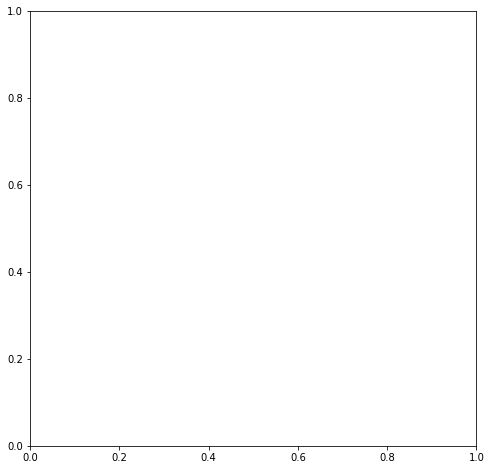

In [5]:
fig, ax = plt.subplots(figsize=(8,8))

In [6]:
Q0 = np.diag([0.01, 0.01, 0.001])**2
Qact = np.diag([0.01, 0.0, 0.001])**2 * 2
xact = x0 + np.random.randn(3, 1) * np.array([0.1, 2, 0.1]).reshape((-1, 1))
R = 0.05
Ract = 0.03

In [7]:
ekf = EKF(F, Q0, R, Yfunc, Hx, x0, P0)
ukf = UKF(F, Q0, R, Yfunc, x0ukf, P0)
sim = Sim(F, Qact, Ract, Yfunc, xact, yield_x=True)

In [8]:
def get_data(ekf, ukf, sim, N):
    ekf_out = []
    ukf_out = []
    sim_out = []
    ukf_step = [(ukf.x, ukf.P)]
    ekf_step = [(ekf.x, ekf.P)]
    for i in xrange(N):
        _sim = next(sim)
        sim_out.append(_sim)
        ekf_out.append(ekf.measure(_sim[1]))
#         ukf_out.append(ukf.measure(_sim[1]))
        
        _ekf = ekf.step()
        _ukf = ukf.step()
        if i != N-1:
            ukf_step.append(_ukf)
            ekf_step.append(_ekf)
    
    return dict(ekf_out=ekf_out, ukf_out=ukf_out, sim_out=sim_out)

# def interact_f(ax, i):
#     y_meas = np.array()

In [9]:
d = get_data(ekf, ukf, sim, 500);

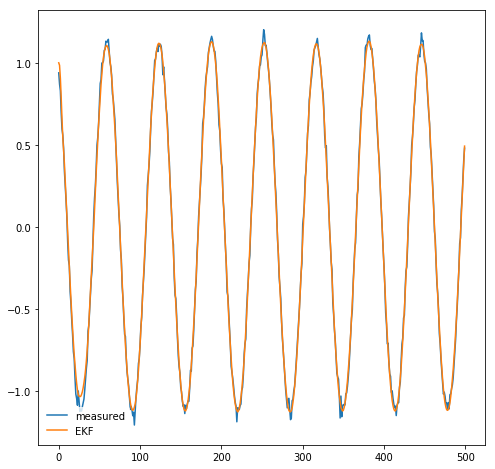

In [11]:
plt.figure(figsize=(8, 8))
y_sim = [y for x, y in d['sim_out']]
plt.plot([y for x, y in d['sim_out']], label='measured')
plt.plot([y_est for y_est, _, _ in d['ekf_out']], label='EKF')
plt.legend()
# plt.plot([y_est for y_est, _, _, in d['ukf_out']][:10])